# **Libreries**

In [139]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder,
                                   PolynomialFeatures
                                        )
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (RandomizedSearchCV,
                                     cross_val_score,
                                     KFold,
                                     train_test_split)
from sklearn.metrics import (r2_score,
                            mean_absolute_error,
                            median_absolute_error,
                            mean_squared_error)
import datetime as dt
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.svm import SVR
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

In [140]:
df = pd.read_csv("Dataverse Train.csv")

In [141]:
df.sample(5)

,Manufacturer,Price,Body Style,Fuel Efficiency,Engine Volume,Powertrain,License Status,Manufacture Year,Variant,Location,Distance Covered,Gearbox,Owner_Type
1813,Mercedes-Benz,114500.0,sedan,285,1.8,Gas,yes,2003,E-Class,oujda,71360,Manual,First
512,BMW,107900.0,other,93,2.5,Petrol,yes,2003,Z4,hosseima,20469,Automatic,First
1534,Mercedes-Benz,NaN,crossover,0,3.0,Diesel,yes,2016,GLS 350,Casablanca,14000,Manual,First
1657,Mercedes-Benz,1230989.0,crossover,0,3.0,Diesel,yes,2016,GL 350,Casablanca,37000,Automatic,First
2405,Mercedes-Benz,148600.0,van,172,2.2,Diesel,yes,2013,Vito,oujda,99000,Manual,First


In [142]:
df.columns

Index(['Manufacturer', 'Price', 'Body Style', 'Fuel Efficiency',
       'Engine Volume', 'Powertrain', 'License Status', 'Manufacture Year',
       'Variant', 'Location', 'Distance Covered', 'Gearbox', 'Owner_Type'],
      dtype='object')

## Data Understanding

In [143]:
num_rows, num_columns = df.shape

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 3041
Number of columns: 13


In [144]:
df.isnull().sum()

Manufacturer          0
Price               128
Body Style            0
Fuel Efficiency       0
Engine Volume       109
Powertrain            0
License Status        0
Manufacture Year      0
Variant               0
Location              0
Distance Covered      0
Gearbox               0
Owner_Type            0
dtype: int64

Column types

In [145]:
df.dtypes

Manufacturer         object
Price               float64
Body Style           object
Fuel Efficiency       int64
Engine Volume       float64
Powertrain           object
License Status       object
Manufacture Year      int64
Variant              object
Location             object
Distance Covered      int64
Gearbox              object
Owner_Type           object
dtype: object

# Data Cleaning

Delete the price null values

In [146]:
df_cleaned = df[df['Price'].notnull()]

Replace null engine volume with mean

In [147]:
df_cleaned['Engine Volume'].fillna(df_cleaned['Engine Volume'].mean(), inplace=True)

In [148]:
df_cleaned.isnull().sum()

Manufacturer        0
Price               0
Body Style          0
Fuel Efficiency     0
Engine Volume       0
Powertrain          0
License Status      0
Manufacture Year    0
Variant             0
Location            0
Distance Covered    0
Gearbox             0
Owner_Type          0
dtype: int64

In [149]:
new_num_rows, num_columns = df_cleaned.shape

print("Number of rows after droping the null values:", num_rows)
print("Number of deleted rows: ",num_rows-new_num_rows)

Number of rows after droping the null values: 3041
Number of deleted rows:  128


In [150]:
# Classify the non-numerical features
cat_features = [x for x in df_cleaned.columns if df[x].dtype == 'O']
# Classify the numerical features
num_features = [x for x in df_cleaned.columns if df[x].dtype != 'O']
# Classify the discrete features
discrete_features = [x for x in num_features
                     if len(df_cleaned[x].unique()) < 25]
# Classify the continuous features
continuous_features = [x for x in num_features
                      if x not in discrete_features]
# Check them out
print(f"Categorical features: {cat_features}\nNumerical features: {num_features}\
\nDiscrete features: {discrete_features}\nContinuous features: {continuous_features}")

Categorical features: ['Manufacturer', 'Body Style', 'Powertrain', 'License Status', 'Variant', 'Location', 'Gearbox', 'Owner_Type']
Numerical features: ['Price', 'Fuel Efficiency', 'Engine Volume', 'Manufacture Year', 'Distance Covered']
Discrete features: []
Continuous features: ['Price', 'Fuel Efficiency', 'Engine Volume', 'Manufacture Year', 'Distance Covered']


<Axes: xlabel='Price', ylabel='Density'>

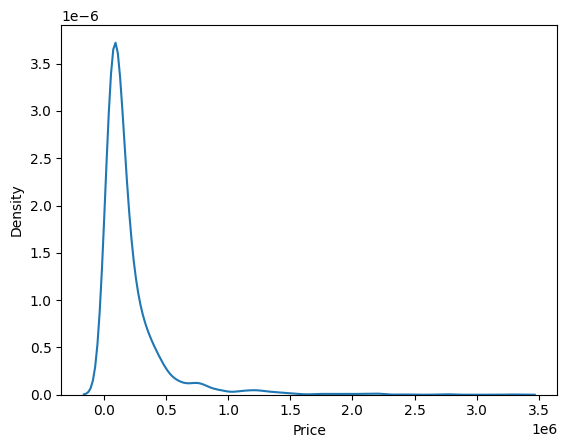

In [151]:
sns.kdeplot(df_cleaned['Price'])

In [152]:
cat_features = ['Manufacturer', 'Body Style', 'Powertrain', 'License Status', 'Location', 'Gearbox', 'Owner_Type','Variant']

In [153]:
for feature in cat_features:
    print(df[feature].value_counts())

Mercedes-Benz    653
Volkswagen       641
BMW              488
Toyota           379
Audi             333
Renault          320
Mitsubishi       227
Name: Manufacturer, dtype: int64
sedan        1166
crossover     629
van           458
other         297
vagon         283
hatch         208
Name: Body Style, dtype: int64
Diesel    1394
Petrol    1114
Gas        425
Other      108
Name: Powertrain, dtype: int64
yes    2753
no      288
Name: License Status, dtype: int64
Casablanca    397
oujda         376
tanger        335
hosseima      335
rabat         322
tetouan       291
mekness       260
sefrou        225
dakhla        201
marrakech     183
agadir        116
Name: Location, dtype: int64
Manual       2161
Automatic     880
Name: Gearbox, dtype: int64
First             2494
Second             483
Third               58
Fourth & Above       6
Name: Owner_Type, dtype: int64
E-Class               138
A6                    126
Vito                  120
Kangoo                 94
Camry        

In [154]:
label_encoder = LabelEncoder()
for feature in cat_features:
    df_cleaned[feature] = label_encoder.fit_transform(df_cleaned[feature])

In [155]:
df_cleaned.dtypes

Manufacturer          int64
Price               float64
Body Style            int64
Fuel Efficiency       int64
Engine Volume       float64
Powertrain            int64
License Status        int64
Manufacture Year      int64
Variant               int64
Location              int64
Distance Covered      int64
Gearbox               int64
Owner_Type            int64
dtype: object

In [156]:
df_cleaned.head()

,Manufacturer,Price,Body Style,Fuel Efficiency,Engine Volume,Powertrain,License Status,Manufacture Year,Variant,Location,Distance Covered,Gearbox,Owner_Type
0,1,39700.0,3,231,2.5,3,1,1990,31,4,70704,1,0
1,2,147500.0,3,317,5.0,3,1,2001,216,5,65650,1,0
2,1,90300.0,3,197,3.0,3,1,2001,33,6,93700,1,0
3,1,525900.0,0,178,4.0,0,1,2012,276,9,72465,1,0
4,0,400500.0,0,115,3.0,0,1,2010,205,8,34000,1,0


In [157]:
df.shape

(3041, 13)

In [158]:
df.sort_values(by = ['Distance Covered'],ascending=False).head(5)

,Manufacturer,Price,Body Style,Fuel Efficiency,Engine Volume,Powertrain,License Status,Manufacture Year,Variant,Location,Distance Covered,Gearbox,Owner_Type
1501,Audi,32000.0,sedan,278,2.5,Diesel,no,1999,A6,sefrou,6500000,Automatic,First
2353,Toyota,143100.0,sedan,200,3.5,Gas,yes,2006,Camry,tetouan,775000,Automatic,First
2257,Audi,144200.0,vagon,182,2.7,Gas,yes,2003,A6 Allroad,sefrou,720000,Manual,First
379,Toyota,373000.0,crossover,44,3.5,Petrol,yes,2012,Highlander,sefrou,480000,Automatic,First
87,Toyota,240989.0,other,65,2.5,Petrol,yes,2012,Camry,tetouan,480000,Manual,First


In [159]:
X = df_cleaned.drop(['Price'], axis=1)
y = df_cleaned['Price']

In [160]:
df_cleaned.to_csv('Cleaned_dataverse.csv',index=False)

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def preprocess_dataframe(df):
    # Drop rows with missing values
    df_cleaned = df.dropna()
    # The location should not determin the price of a care
    df_cleaned.drop("Location", axis = 1, inplace = True)

    sns.distplot(df_cleaned['Price']);

    # Initialize LabelEncoder / StandardScaler
    label_encoder = LabelEncoder()
    scaler = StandardScaler()



    # Standardize numerical features
    num_features = [x for x in df_cleaned.columns if df_cleaned[x].dtype != 'O']
    num_features_to_standardize = [x for x in num_features if x != 'Price']  # Exclude 'Price' from standardization

    # Create a new figure and a set of subplots
    fig, axs = plt.subplots(nrows=len(num_features_to_standardize), figsize=(5, 4*len(num_features_to_standardize)))

    # Create a box plot for each column
    for i, col in enumerate(num_features_to_standardize):
        sns.boxplot(df_cleaned[col], ax=axs[i])
        axs[i].set_title(col)

    plt.tight_layout()
    plt.show()

    # Create a DataFrame for the numerical features to standardize
    X_num_to_standardize = df_cleaned[num_features_to_standardize]

    # Fit and transform only the selected numerical columns
    X_num_standardized = pd.DataFrame(scaler.fit_transform(X_num_to_standardize), columns=num_features_to_standardize, index=X_num_to_standardize.index)

    # Apply label encoding to categorical features
    cat_features = ['Variant', 'Manufacturer', 'Body Style', 'Powertrain', 'License Status', 'Gearbox', 'Owner_Type']
    for feature in cat_features:
        df_cleaned[feature] = label_encoder.fit_transform(df_cleaned[feature])

    # Separate features (X) and target variable (y)
    X = pd.concat([X_num_standardized, df_cleaned[cat_features]], axis=1)
    y = df_cleaned['Price']

    return X, y


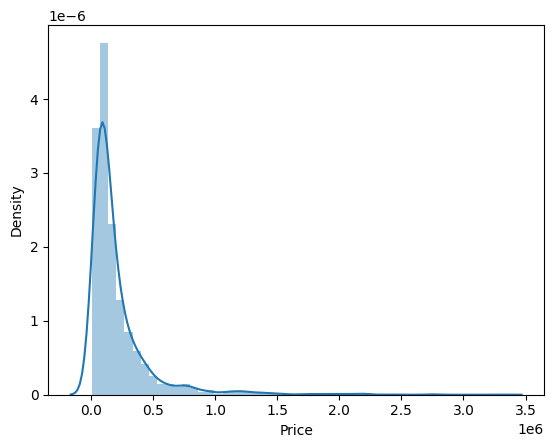

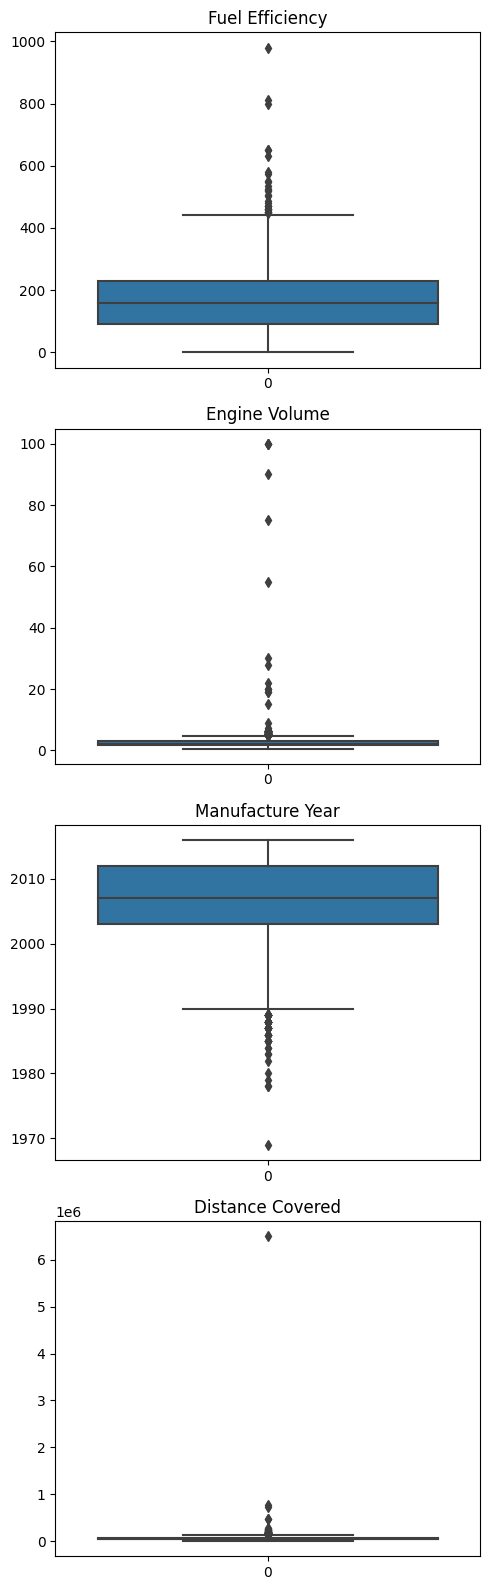

In [182]:
X,y = preprocess_dataframe(df)

In [163]:
X.head()

,Fuel Efficiency,Engine Volume,Manufacture Year,Distance Covered,Variant,Manufacturer,Body Style,Powertrain,License Status,Location,Gearbox,Owner_Type
0,0.645036,-0.049852,-2.438903,0.084427,31,1,3,3,1,4,1,0
1,1.465553,0.542856,-0.799597,0.044904,212,2,3,3,1,5,1,0
2,0.320645,0.068690,-0.799597,0.264257,33,1,3,3,1,6,1,0
3,0.139368,0.305773,0.839709,0.098198,272,1,0,0,1,9,1,0
4,-0.461708,0.068690,0.541654,-0.202602,201,0,0,0,1,8,1,0


In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [185]:
# Define the pipelines
pipelines = []
poly = PolynomialFeatures(degree=2)
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
pipelines.append(('ScaledPoly', Pipeline([('Scaler', StandardScaler()),('Poly', poly),('LR', LinearRegression())])))
pipelines.append(('ScaledXGB', Pipeline([('Scaler', StandardScaler()),('XGB', XGBRegressor())])))

In [186]:
# Evaluate each model in turn
results = []
names = []
for name, model in pipelines:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    results.append((r2, mae, medae, mse))
    names.append(name)

    msg = "%s:\n R2 Score: %f\n Mean Absolute Error: %f\n Median Absolute Error: %f\n Mean Squared Error: %f" % (name, r2, mae, medae, mse)
    print(msg)


ScaledLR:
 R2 Score: 0.377046
 Mean Absolute Error: 124894.134213
 Median Absolute Error: 79949.874906
 Mean Squared Error: 57355243921.974495
ScaledRF:
 R2 Score: 0.889083
 Mean Absolute Error: 45019.462201
 Median Absolute Error: 16371.230000
 Mean Squared Error: 10212071518.820017
ScaledSVR:
 R2 Score: -0.107565
 Mean Absolute Error: 151799.297150
 Median Absolute Error: 71467.741911
 Mean Squared Error: 101973233914.415268
ScaledPoly:
 R2 Score: -2.750178
 Mean Absolute Error: 115643.314968
 Median Absolute Error: 52912.710777
 Mean Squared Error: 345278051245.525574
ScaledXGB:
 R2 Score: 0.876820
 Mean Absolute Error: 42345.654824
 Median Absolute Error: 15570.070312
 Mean Squared Error: 11341151656.579069


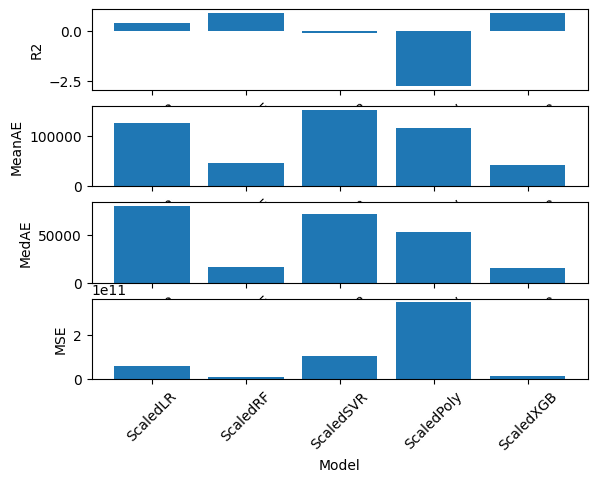

In [187]:
import numpy as np
# Convert results to a numpy array for easier manipulation
results_array = np.array(results)

# Create a figure and a set of subplots
fig, axs = plt.subplots(4)

# Plot each metric
for i, metric in enumerate(['R2', 'MeanAE', 'MedAE', 'MSE']):
    axs[i].bar(names, results_array[:, i])
    axs[i].set_ylabel(metric)
    axs[i].set_xlabel('Model')
    axs[i].set_xticks(names)
    axs[i].set_xticklabels(names, rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [168]:
# Create the random grid
random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [ 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'n_jobs': [-1],  # Use all available processors
    'random_state': [42]  # Set a seed for reproducibility
}
print(random_grid)

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['sqrt', 'log2'], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'n_jobs': [-1], 'random_state': [42]}


In [169]:
# Using the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# searching across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,n_iter = 100, param_distributions = random_grid, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000],
                                        'n_jobs': [-1], 'random_state': [42]},
                   random_state=42, verbose=2)

In [170]:
rf_random.best_params_

{'random_state': 42,
 'n_jobs': -1,
 'n_estimators': 377,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 30,
 'bootstrap': False}

In [188]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=30, bootstrap=False)
# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=30, max_features='sqrt',
                      n_estimators=300, n_jobs=-1, random_state=42)

In [172]:
X_test.head()

,Fuel Efficiency,Engine Volume,Manufacture Year,Distance Covered,Variant,Manufacturer,Body Style,Powertrain,License Status,Location,Gearbox,Owner_Type
1180,-0.146858,-0.286935,0.839709,-0.165613,145,4,5,0,1,9,0,0
1130,-0.003745,-0.049852,0.243598,-0.061840,251,6,5,0,1,4,1,0
1642,-0.270890,0.187231,0.392626,0.301301,92,5,2,1,1,7,1,0
2718,1.036212,-0.192101,-1.246680,-0.194782,189,6,3,0,0,10,1,2
1639,-0.776557,0.068690,0.839709,0.127054,40,1,2,3,1,5,1,0


In [189]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Display evaluation metrics
print(f'R2 Score: {r2:.4f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Median Absolute Error: {medae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')

R2 Score: 0.9299
Mean Absolute Error: 39009.97
Median Absolute Error: 17091.19
Mean Squared Error: 6450756665.93


In [174]:
for feature in cat_features:
        df_cleaned[feature + '_encoded'] = label_encoder.fit_transform(df_cleaned[feature])
        print(f"{feature}:")
        for original_value, encoded_value in zip(df_cleaned[feature].unique(), df_cleaned[feature + '_encoded'].unique()):
            print(f"  {original_value}: {encoded_value}")

Manufacturer:
  1: 1
  2: 2
  0: 0
  4: 4
  6: 6
  5: 5
  3: 3
Body Style:
  3: 3
  0: 0
  4: 4
  5: 5
  2: 2
  1: 1
Powertrain:
  3: 3
  0: 0
  2: 2
  1: 1
License Status:
  1: 1
  0: 0
Location:
  4: 4
  5: 5
  6: 6
  9: 9
  8: 8
  3: 3
  10: 10
  7: 7
  0: 0
  1: 1
  2: 2
Gearbox:
  1: 1
  0: 0
Owner_Type:
  0: 0
  2: 2
  3: 3
  1: 1
Variant:
  31: 31
  216: 216
  33: 33
  276: 276
  205: 205
  153: 153
  94: 94
  255: 255
  60: 60
  195: 195
  194: 194
  108: 108
  44: 44
  172: 172
  111: 111
  188: 188
  28: 28
  77: 77
  164: 164
  273: 273
  264: 264
  193: 193
  76: 76
  200: 200
  147: 147
  263: 263
  58: 58
  215: 215
  1: 1
  178: 178
  10: 10
  248: 248
  192: 192
  270: 270
  149: 149
  262: 262
  162: 162
  61: 61
  208: 208
  138: 138
  16: 16
  64: 64
  148: 148
  62: 62
  39: 39
  235: 235
  95: 95
  21: 21
  139: 139
  184: 184
  130: 130
  121: 121
  213: 213
  165: 165
  19: 19
  185: 185
  67: 67
  253: 253
  29: 29
  150: 150
  189: 189
  103: 103
  154: 154
  1

## Heat Map

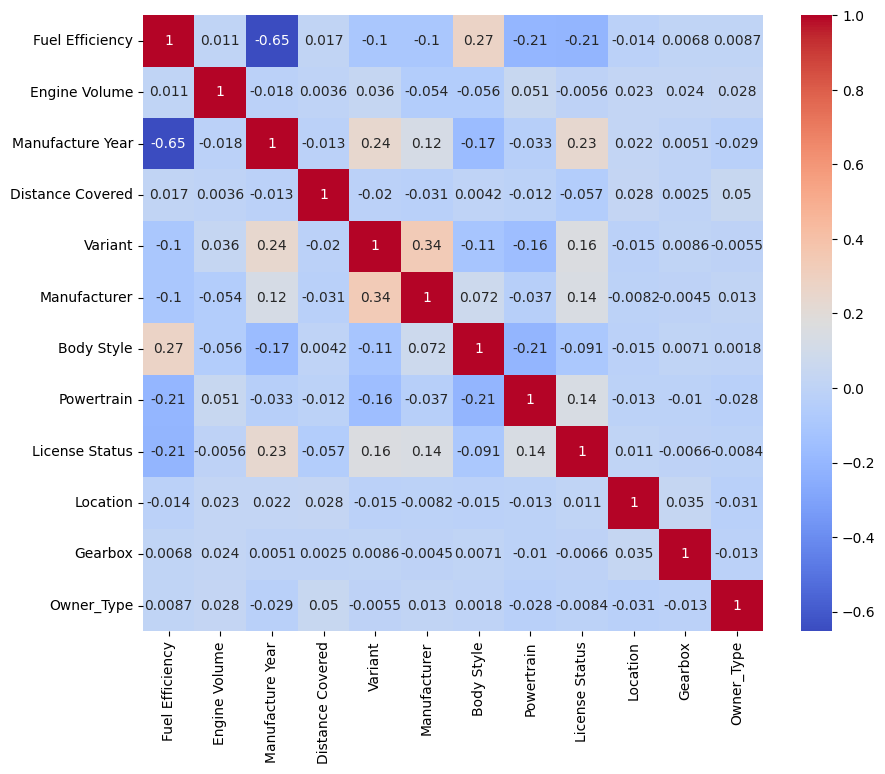

In [175]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(X.corr(), annot = True, cmap = 'coolwarm')
plt.show()

# Deep Learning Model

In [176]:
!pip install  keras

In [177]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

## 2 - Build The Model